In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing

from scipy.special import expit

from lib import *

%matplotlib inline

/home/tronco/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/tronco/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
fields = ['Fecha Hora', 'Velocidad Viento']

data_raw = pd.read_csv('../data/meteorologia.csv', usecols=fields,index_col="Fecha Hora",squeeze=True)
data_raw.index = pd.to_datetime(data_raw.index,format="%d-%m-%Y %H:%M")

In [3]:
prediction_steps = 12
input_steps = 120

In [4]:
train_perc = 0.8

datalen = len(data_raw)
trainlen = int(train_perc*(datalen))

minmax = preprocessing.MinMaxScaler(feature_range=(-1,1)) 
standarization = preprocessing.StandardScaler()

minmax.fit(data_raw[:trainlen].reshape(-1,1))
standarization.fit(data_raw[:trainlen].reshape(-1,1))

preproc = minmax

data = preproc.transform(data_raw.reshape(-1,1)).reshape((-1,)) if preproc else data_raw


/home/tronco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/tronco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/tronco/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [5]:
X,y = getDataWindowed(data,input_steps,prediction_steps)

In [6]:
train_data,train_output = X[:trainlen],y[:trainlen]
test_data, test_output  = X[trainlen:-prediction_steps],y[trainlen:-prediction_steps]

In [7]:
params = {'spectral_radius':np.arange(0.1,1,0.3),
         'sparsity':np.arange(0.01,0.11,0.03), 'leaking_rate':np.arange(0.1,1,0.3), 'regularization':10**np.arange(-10,0,5)}

In [8]:
folds = createFolds(train_data.shape[0],5)
clf = ESN(random_state=0)
gs = GridSearchCV(clf, params, cv=folds, verbose=True, n_jobs=-1, scoring='r2')
gs.fit(train_data,train_output)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/home/tronco/anaconda3/lib/python3.5/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)
/home/tronco/anaconda3/lib/python3.5/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)
/home/tronco/anaconda3/lib/python3.5/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)
/home/tronco/anaconda3/lib/python3.5/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Defaul

GridSearchCV(cv=[(array([   0,    1, ..., 5190, 5191]), array([ 5192,  5193, ..., 10382, 10383])), (array([    0,     1, ..., 10382, 10383]), array([10384, 10385, ..., 15574, 15575])), (array([    0,     1, ..., 15574, 15575]), array([15576, 15577, ..., 20766, 20767])), (array([    0,     1, ..., 20766, 20767]), array([20768, 20769, ..., 25958, 25959])), (array([    0,     1, ..., 25958, 25959]), array([25960, 25961, ..., 31150, 31151]))],
       error_score='raise',
       estimator=ESN(activation=<ufunc 'tanh'>, leaking_rate=0.3, n_hidden=100, random_state=0,
  regularization=1e-08, sparsity=0.95, spectral_radius=None, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'regularization': array([0, 0]), 'sparsity': array([ 0.01,  0.04,  0.07,  0.1 ]), 'leaking_rate': array([ 0.1,  0.4,  0.7]), 'spectral_radius': array([ 0.1,  0.4,  0.7])},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=True)

In [9]:
clf.set_params(n_hidden=1000,**gs.best_params_)
#clf = ESN(random_state=0)

ESN(activation=<ufunc 'tanh'>, leaking_rate=0.70000000000000007,
  n_hidden=1000, random_state=0, regularization=0,
  sparsity=0.040000000000000001, spectral_radius=0.10000000000000001,
  verbose=False)

In [10]:
clf.fit(train_data, train_output)

ESN(activation=<ufunc 'tanh'>, leaking_rate=0.70000000000000007,
  n_hidden=1000, random_state=0, regularization=0,
  sparsity=0.040000000000000001, spectral_radius=0.10000000000000001,
  verbose=False)

In [11]:
#X_test = test_data
#y_test = test_output
#clf.score(X_test,y_test)

In [12]:
y_pred = clf.predict(test_data)

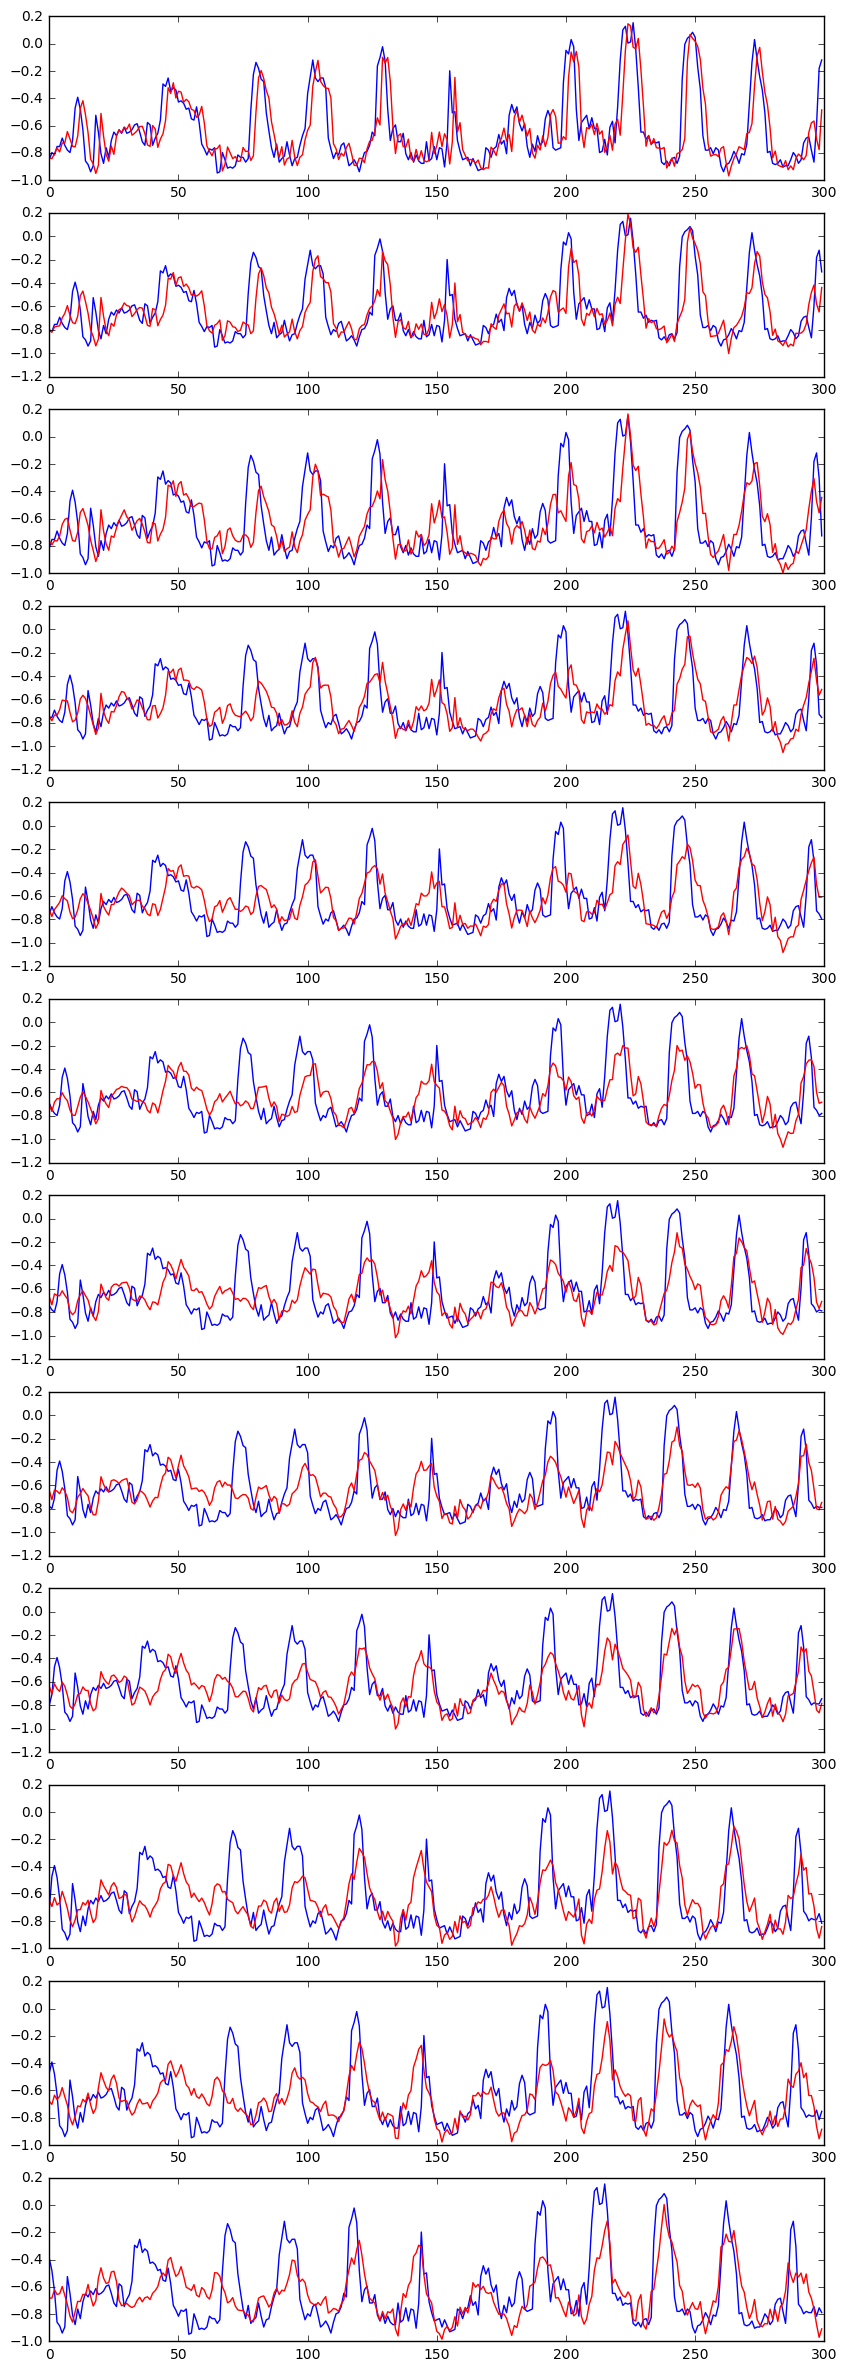

In [13]:
fig = plt.figure(figsize=(10,30))
for i in range(prediction_steps):
    ax = fig.add_subplot(12,1,i+1)
    ax.plot(test_output[:300,i])
    ax.plot(y_pred[:300,i],'r')

In [14]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error

In [15]:
r2_score(y_true=test_output, y_pred=y_pred)

/home/tronco/anaconda3/lib/python3.5/site-packages/sklearn/metrics/regression.py:482: DeprecationWarning: Default 'multioutput' behavior now corresponds to 'variance_weighted' value which is deprecated since 0.17, it will be changed to 'uniform_average' starting from 0.19.
  DeprecationWarning)


0.30229463261833234

In [16]:
mean_absolute_error(y_true=test_output,y_pred=y_pred)

0.14651551123909901

In [17]:
mean_squared_error(y_true=test_output, y_pred = y_pred)

0.039650782104585107